# Voice Gender Recognition (Machine Learning)

In [1]:
%matplotlib inline

*Import libraries*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

*Global parameters*

In [3]:
num_features = 20

*Paths*

In [4]:
figs_path = '../figs/'
data_path = '../data/'

## 1. Preprocessing

*Read dataset*

In [5]:
if num_features == 20:
    dataset = pd.read_csv(data_path + 'voice.csv')
elif num_features == 2:
    dataset = pd.read_csv(data_path + 'embedded_voice.csv')
else:
    raise NotImplementedError('Unsupported scenario')

*Validate structure*

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   int6

*Feature matrix*

In [7]:
features = dataset.iloc[:, :-1].values

*Label vector*

In [8]:
labels = dataset.iloc[:, -1].values

## 2. Visualization

*Display projection*

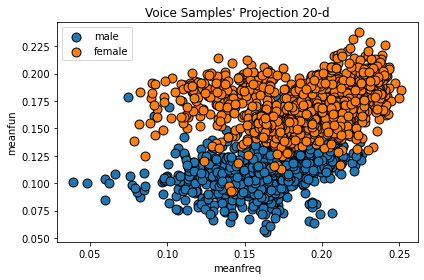

In [9]:
(f1, f2) = (0, 12) if num_features == 20 else (0, 1)
plt.figure()
plt.scatter(features[labels == 1, f1], features[labels == 1, f2], s=80, edgecolors='black', label='male')
plt.scatter(features[labels == 0, f1], features[labels == 0, f2], s=80, edgecolors='black', label='female')
plt.ylabel(dataset.columns[f2])
plt.xlabel(dataset.columns[f1])
plt.title("Voice Samples' Projection {}-d".format(num_features))
plt.legend()
plt.tight_layout()
plt.savefig(figs_path + 'voice_projection_{}d.pdf'.format(num_features))
plt.show()

## 3. Learning

*Split in train and rest*

In [10]:
features_train, features_rest, labels_train, labels_rest = train_test_split(features, labels, test_size=0.40)

*Split in validation and test*

In [11]:
features_val, features_test, labels_val, labels_test = train_test_split(features, labels, test_size=0.50)

*Scale features*

In [12]:
sc = MinMaxScaler()
features_train = sc.fit_transform(features_train)
features_val = sc.transform(features_val)
features_test = sc.transform(features_test)

### Decision Tree

*Train model*

In [13]:
classifier1 = DecisionTreeClassifier(criterion='entropy', max_depth=8)
classifier1.fit(features_train, labels_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8)

*Plot decision tree*

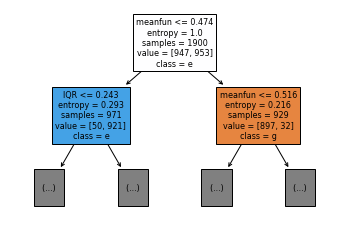

In [14]:
plt.figure()
_ = plot_tree(classifier1, max_depth=1, feature_names=dataset.columns, class_names='gender', filled=True)
plt.savefig(figs_path + 'decision_tree_{}d.pdf'.format(num_features))

### SVM linear Kernel

*Train model*

In [15]:
classifier2 = SVC(kernel='linear', probability=True)
classifier2.fit(features_train, labels_train)

SVC(kernel='linear', probability=True)

### SVM polynomial Kernel

*Train model*

In [16]:
classifier3 = SVC(kernel='poly', probability=True)
classifier3.fit(features_train, labels_train)

SVC(kernel='poly', probability=True)

### SVM RBF Kernel

*Train model*

In [17]:
classifier4 = SVC(probability=True)
classifier4.fit(features_train, labels_train)

SVC(probability=True)

### Logistic Regression

*Train model*

In [18]:
classifier5 = LogisticRegression()
classifier5.fit(features_train, labels_train)

LogisticRegression()

## 4. Evaluation

*Classifiers*

In [19]:
classifiers = [classifier1, classifier2, classifier3, classifier4, classifier5]
classifiers_names = ['Decision Tree', 'Linear SVM', 'Polynomial SVM', 'RBF SVM', 'Logistic Regression']

*Compute performance metrics*

In [20]:
def compute_metrics(labels_eval, labels_pred):
    metrics = {}
    tn, fp, fn, tp = confusion_matrix(labels_eval, labels_pred).ravel()
    metrics['accuracy'] = (tp + tn) / (tp + tn + fp + fn)
    metrics['sensitivity'] = tp / (tp + fn)
    metrics['specificity'] = tn / (tn + fp)
    return metrics

*Assess classifiers' performance*

In [21]:
def assess_performance(classifiers, features_eval, labels_eval):
    performance = {}
    for index, classifier in enumerate(classifiers):
        labels_pred = classifier.predict(features_eval)
        performance['C{}'.format(index + 1)] = compute_metrics(labels_eval, labels_pred)
    return performance

*Evaluate classifiers' performance in the validation set*

In [22]:
performance_val = assess_performance(classifiers, features_val, labels_val)
pd.DataFrame(performance_val).T

,accuracy,sensitivity,specificity
C1,0.982323,0.978697,0.986005
C2,0.970960,0.973684,0.968193
C3,0.979167,0.977444,0.980916
C4,0.974747,0.972431,0.977099
C5,0.965278,0.973684,0.956743


*Evaluate classifiers' performance in the test set*

In [23]:
performance_test = assess_performance(classifiers, features_test, labels_test)
pd.DataFrame(performance_test).T

,accuracy,sensitivity,specificity
C1,0.989899,0.988550,0.991228
C2,0.976010,0.983461,0.968672
C3,0.982323,0.982188,0.982456
C4,0.978535,0.980916,0.976190
C5,0.972222,0.984733,0.959900


*Plot ROC curves*

<Figure size 432x288 with 0 Axes>

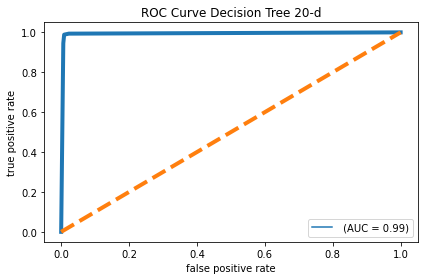

<Figure size 432x288 with 0 Axes>

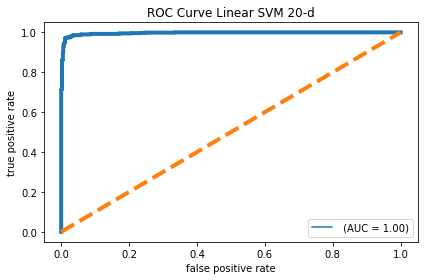

<Figure size 432x288 with 0 Axes>

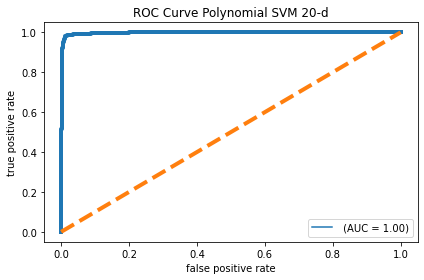

<Figure size 432x288 with 0 Axes>

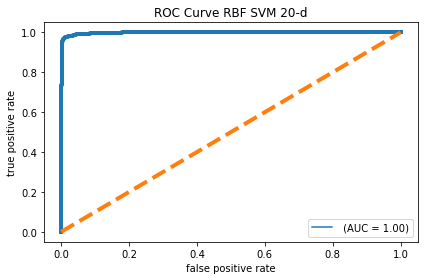

<Figure size 432x288 with 0 Axes>

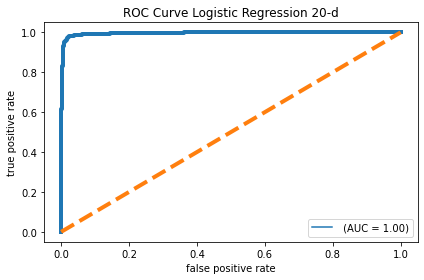

In [24]:
for index, classifier in enumerate(classifiers):
    classifier_name = classifiers_names[index]
    plt.figure()
    roc_figure = plot_roc_curve(classifier, features_test, labels_test, name='')
    roc_figure.line_.set_linewidth(4)
    plt.plot([0.0, 1.0], [0.0, 1.0], '--', linewidth=4)
    plt.ylabel('true positive rate')
    plt.xlabel('false positive rate')
    plt.title('ROC Curve {} {}-d'.format(classifier_name, num_features))
    plt.tight_layout()
    plt.savefig(figs_path + 'roc_{}_{}d.pdf'.format(classifier_name.lower(), num_features))
    plt.show()